In [1]:
# Data manipulation
# ==============================================================================
import warnings
import shap
import math
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
from IAT_dataparser import IATDataParser

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================


# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
scapy.loading WARNING Wireshark is installed, but cannot read manuf !


Biflow packet data:  {'timestamp': [1619005758.091158, 1619005758.183335], 'src_port': [67, 67], 'dst_port': [68, 68], 'packet_dir': [1, 1], 'IP_packet_bytes': [328, 328], 'IP_header_bytes': [20, 20], 'L4_payload_bytes': [300, 300], 'L4_header_bytes': [8, 8], 'iat': [0.0, 0.092177], 'TCP_win_size': [0, 0], 'TCP_flags': ['', ''], 'L4_raw_payload': [[2, 1, 6, 0, 27, 101, 65, 23, 0, 0, 0, 0, 0, 0, 0, 0, 192, 168, 20, 111, 192, 168, 20, 254, 0, 0, 0, 0, 248, 207, 197, 208, 13, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [2]:
csv_file1 = r'C:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\dataset_exploration\saved_dataframes\biflow_15.csv'

test_IAT = pd.read_csv(csv_file1)

test_IAT = test_IAT[100:1100]

Steps:  200
Train dates : 100 --- 899  (n=800)
Test dates  : 900 --- 1099  (n=200)


c:\Users\yylee\OneDrive\Desktop\yylee\network-pred\network-prediction\net-pred\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


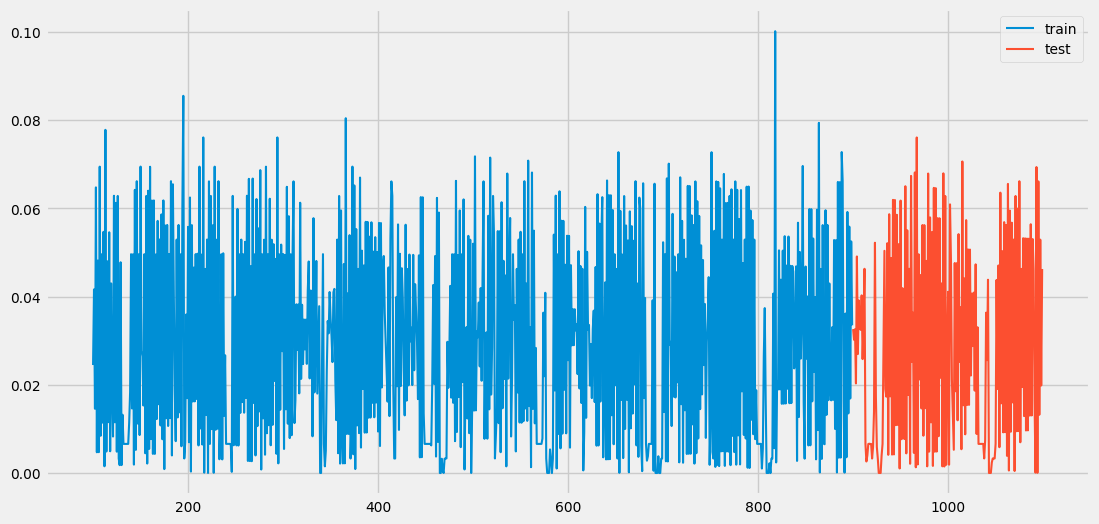

In [3]:
# Split data into train-test
# ==============================================================================
steps = len(test_IAT) * 0.2  # 80/20 split
steps = math.floor(steps)
print("Steps: ", steps)

data_train = test_IAT[:-steps]
data_test = test_IAT[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
ax.legend()

In [4]:
def get_lag_list(lag, gap=None):
    """
    Returns a list of integers from 1 to lag, optionally accounting for a specified gap.

    Parameters:
    - lag (int): The end of the range.
    - gap (int, optional): The gap to account for. If specified, only values greater than the gap are included.

    Returns:
    - list: A list of integers.
    """
    if gap is None:
        return list(range(1, lag + 1))
    else:
        return list(range(gap + 1, lag + 1))


# get_lag_list(steps, 0)

In [5]:
print(get_lag_list(200, 90))

[91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]


In [6]:
from tqdm import tqdm

def optimal_gap(data_train, data_test, lag, start, end, step=1):
    losses = []
    gaps = []
    lags = []

    for gap in range(start, end, step):
        if gap > end - step:
            break

        # print("gap: ", gap)
        # print("get lag list: ", get_lag_list(lag, gap))
        lags.append(get_lag_list(lag, gap))
        gaps.append(gap)

    print("lags: ", lags)
    print("gaps: ", gaps)

    for lag in tqdm(lags):
        forecaster = ForecasterAutoreg(
            regressor=RandomForestRegressor(random_state=123),
            lags=lag
        )

        forecaster.fit(y=data_train['Interarrival_scaled'])

        predictions = forecaster.predict(steps=200)

        error_mse = mean_squared_error(
            y_true=data_test['Interarrival_scaled'],
            y_pred=predictions
        )

        losses.append(error_mse)

    return losses, gaps

lags:  [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4

100%|██████████| 10/10 [00:40<00:00,  4.02s/it]


Lags:  [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]


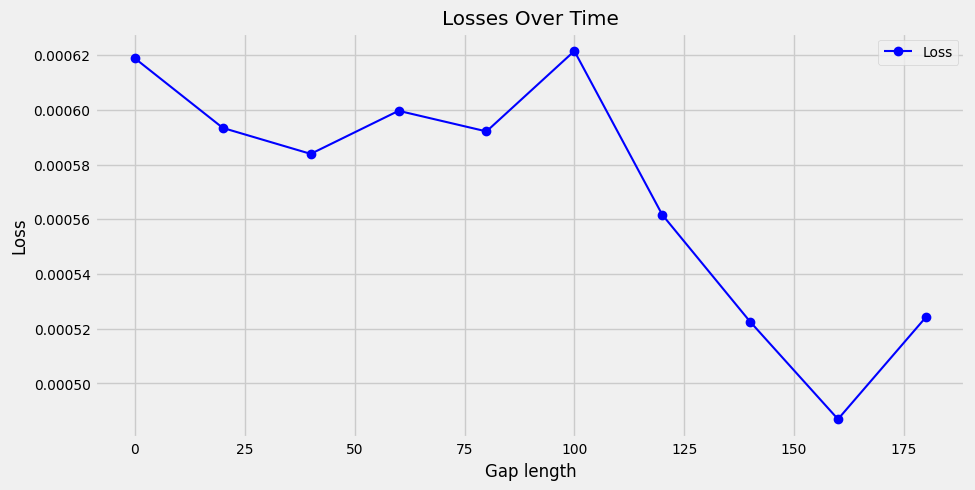

In [7]:
losses, gaps = optimal_gap(data_train, data_test, 200, 0, 200, 20)

print("Lags: ", gaps)
# lags = list(range(steps, len(data_train), 10))

# Ensure the length of losses matches the length of lags
if len(losses) != len(gaps):
    raise ValueError(
        "The length of losses must match the number of lags generated by the specified range.")

plt.figure(figsize=(10, 5))
plt.plot(gaps, losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Losses Over Time')
plt.xlabel('Gap length')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [8]:
# min_gap = gaps.index(min(gaps))
# print("min gap: ", min_gap)

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=get_lag_list(200, 160) # To be defined
)
forecaster.fit(y=data_train['Interarrival_scaled'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 
Transformer for y: None 
Transformer for exog: None 
Window size: 200 
Weight function included: False 
Diffe

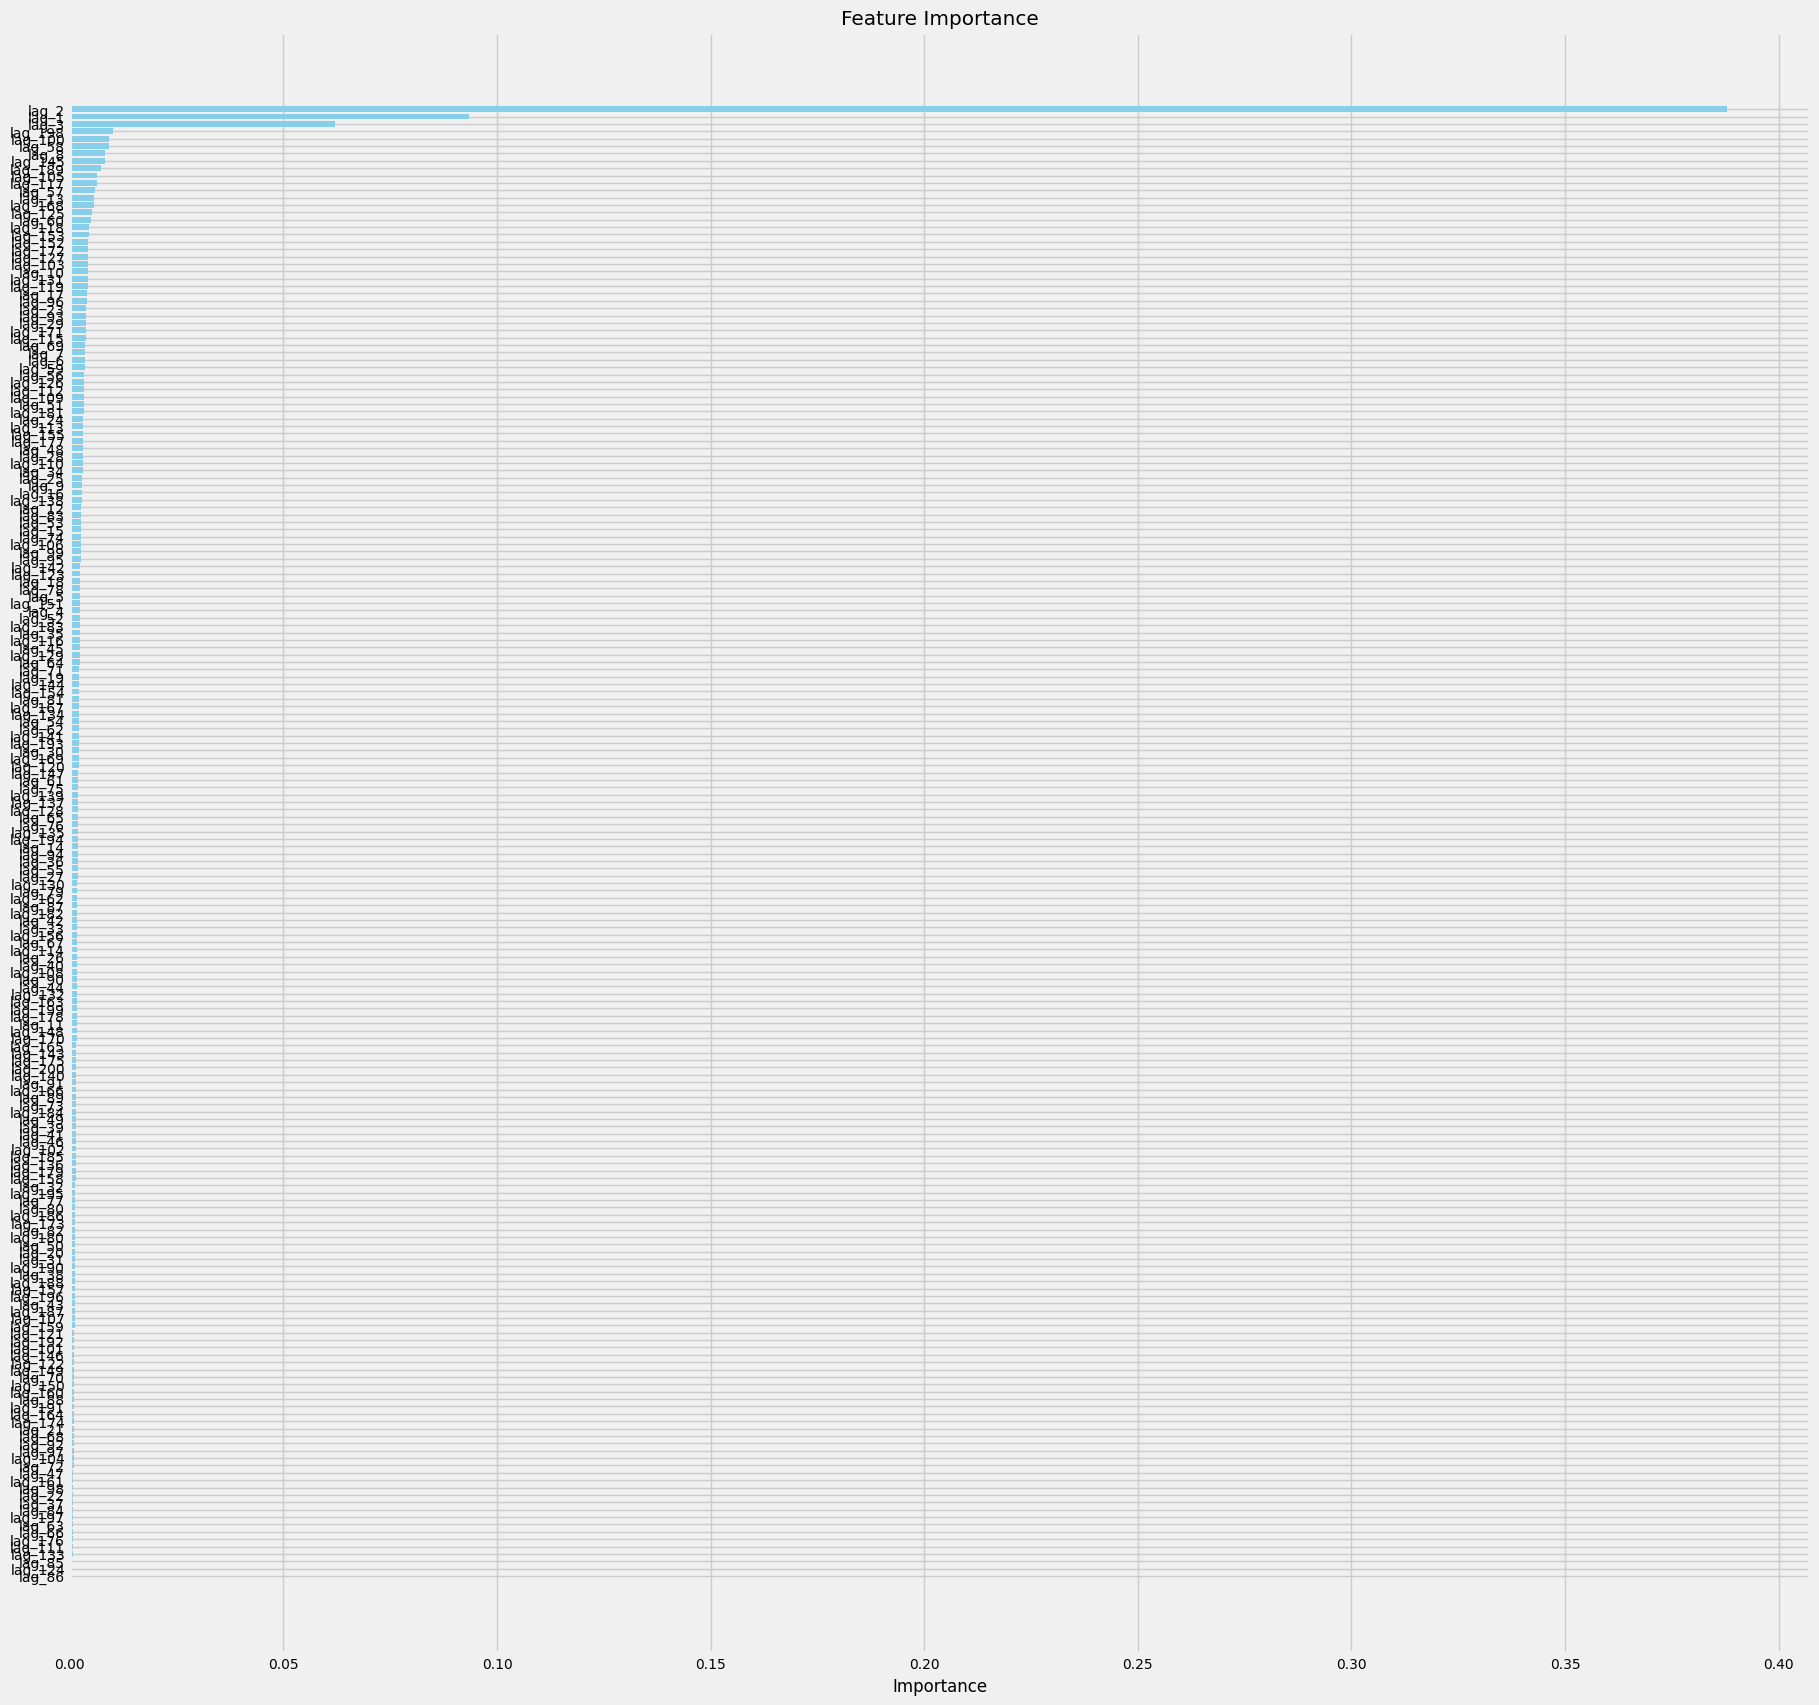

In [9]:
# Retrieving feature importance
feat_impt_df = forecaster.get_feature_importances()

# # Sort DataFrame by importance
# feat_impt_df = feat_impt_df.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(20, 20))
plt.barh(feat_impt_df['feature'], feat_impt_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [10]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)
predictions.head(5)

900    0.037046
901    0.022365
902    0.031022
903    0.020703
904    0.036178
Name: pred, dtype: float64

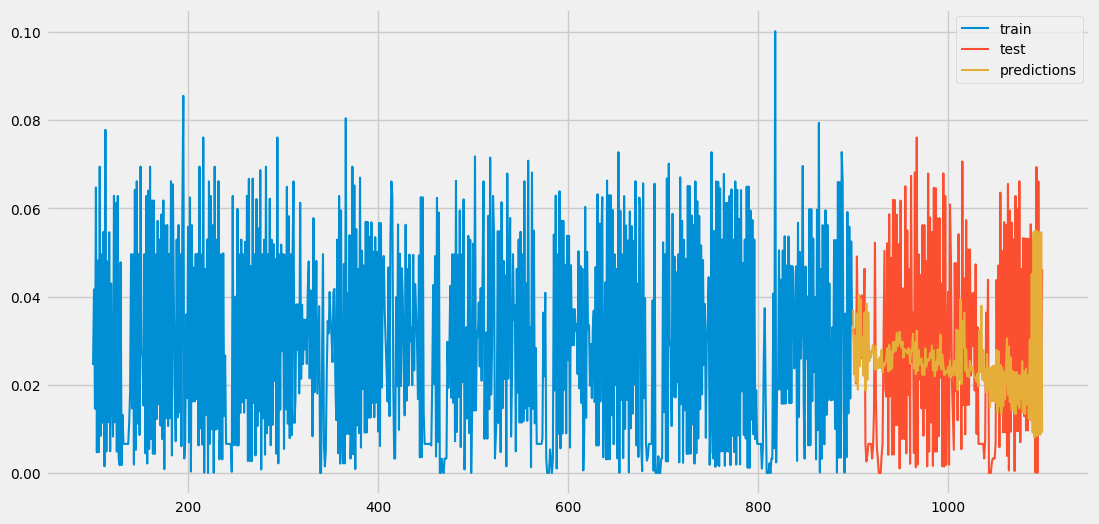

In [11]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [12]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['Interarrival_scaled'],
    y_pred=predictions
)
print(f"Optimal Gap Test error (MSE): {error_mse}")

Optimal Gap Test error (MSE): 0.0006187874500276726


In [13]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    # lags=get_lag_list(steps, 0)
    lags=get_lag_list(270, 180)
)
forecaster.fit(y=data_train['Interarrival_scaled'])

In [14]:
from skforecast.model_selection import backtesting_forecaster

metric, predictions_training = backtesting_forecaster(
    forecaster=forecaster,
    y=data_train['Interarrival_scaled'],
    steps=1,
    metric='mean_squared_error',
    initial_train_size=None,
    refit=False,
    verbose=False,
    show_progress=True
)

print(f"Backtest training error: {metric}")

  0%|          | 0/530 [00:00<?, ?it/s]

100%|██████████| 530/530 [00:01<00:00, 377.98it/s]


Backtest training error: 6.339780410063628e-05


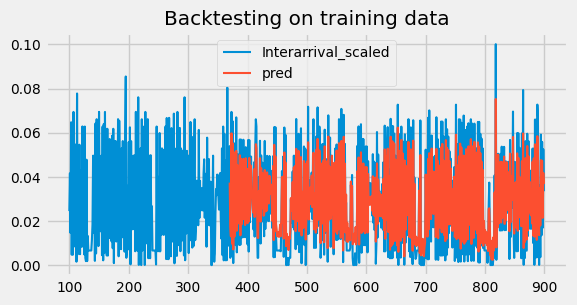

In [15]:
# Plot training predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train['Interarrival_scaled'].plot(ax=ax)
predictions_training.plot(ax=ax)
ax.set_title("Backtesting on training data")
ax.legend()
plt.show()